<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import datetime
from itertools import chain
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def boundaries(N, session_length, window_size):
    ran = lambda x: x+session_length
    slice_list=[(i, ran(i) if ran(i) < N else N) for i in range(0, N, window_size)]
    return slice_list

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    user_re = re.compile("user([\d]+)[.]")
    list_times_incomplete = []
    list_sites = []
    list_users = []
    list_timediffs = []
    
    with open(site_freq_path,"rb") as f:
        site_freq = pickle.load(f)

    for file in tqdm(glob(path_to_csv_files+'/*')):
        sites_raw = pd.read_csv(file)['site'].apply(lambda x: site_freq[x][0])
        timestamps_raw = pd.read_csv(file)['timestamp']

        indices = boundaries(len(sites_raw),session_length,window_size)
        list_users += [int(re.search(user_re, file).group(1))] * len(indices)
        list_times_incomplete += [timestamps_raw.values[ind[0]:ind[1]].reshape(-1) for ind in indices]
        list_sites += [sites_raw.values[ind[0]:ind[1]].reshape(-1) for ind in indices]
        

    list_times = [list(map(np.datetime64, i)) for i in list_times_incomplete]
    total_time = [(i[-1]-i[0]).astype(int) for i in list_times]
    unique = [len(np.unique(i)) for i in list_sites]
    
    for session in list_times:
        localdiff = [(session[i]-session[i-1]).astype(int) for i in range(1, len(session))]
        list_timediffs.append(localdiff)
        
    df_tstamps = pd.DataFrame(list_times, columns=[f'time{i}' for i in range(session_length)])
    df_sites = pd.DataFrame(list_sites)
    df_timediffs = pd.DataFrame(list_timediffs) 
    df = pd.concat([df_sites, df_timediffs], axis=1)
    df = df.fillna(0).astype('int')
    
    df['total'] = total_time
    df['unique'] = unique
    df['hours'] = df_tstamps['time0'].dt.hour
    df['days'] = df_tstamps['time0'].dt.dayofweek
    df['user_id'] = list_users
    df.columns = feature_names
    
    return df

**Проверим функцию на игрушечном примере.**

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.31it/s]


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.93it/s]


Wall time: 2.65 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:09<00:00, 16.19it/s]


Wall time: 25.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.loc[:,['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:,['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [10]:
np.median(train_data_10users.session_timespan)

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [11]:
np.median(train_data_10users.day_of_week)

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [12]:
np.median(train_data_150users.start_hour)

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [13]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Частота')

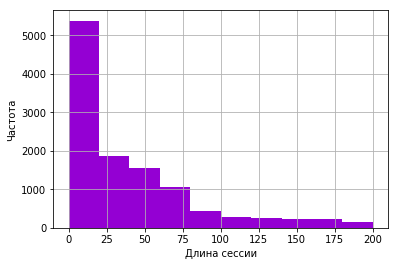

In [17]:
train_data_10users['session_timespan'].hist(color='darkviolet', range=(0, 200))
plt.xlabel('Длина сессии')
plt.ylabel('Частота')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Частота')

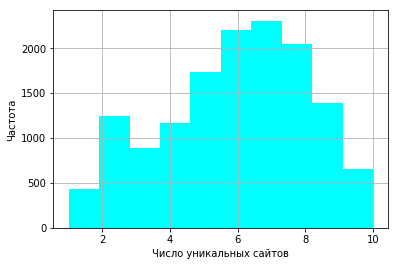

In [18]:
train_data_10users['#unique_sites'].hist(color='aqua')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Частота')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

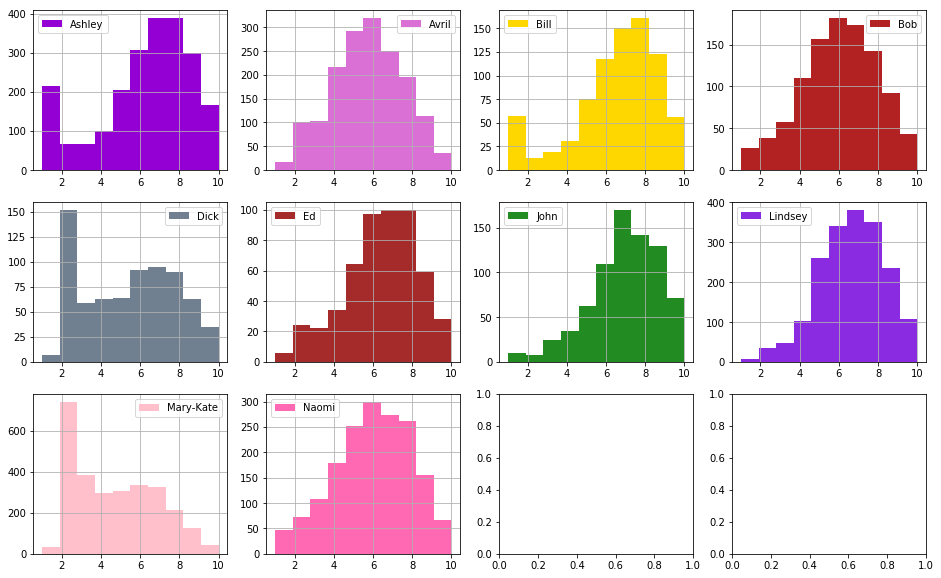

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
    
indices = [(i, j) for i in range(3) for j in range(4)]
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['#unique_sites'].hist(ax=axes[indices[idx]], color=color_dic[user])
    axes[indices[idx]].legend([user])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Частота')

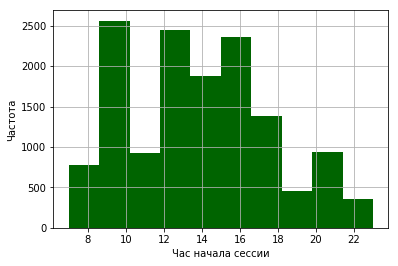

In [20]:
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Частота')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

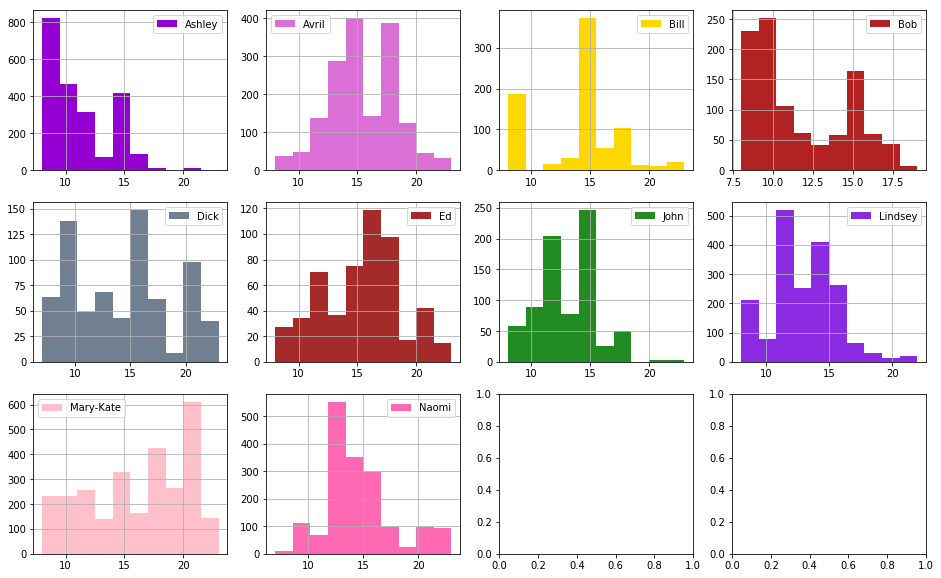

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому

indices = [(i, j) for i in range(3) for j in range(4)]
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['start_hour'].hist(ax=axes[indices[idx]], color=color_dic[user])
    axes[indices[idx]].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Частота')

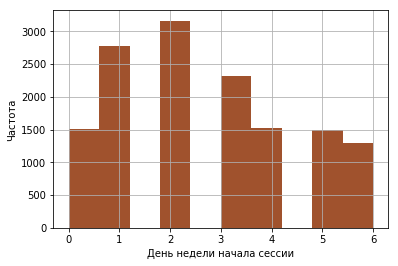

In [22]:
train_data_10users['day_of_week'].hist(color='sienna')
plt.xlabel('День недели начала сессии')
plt.ylabel('Частота')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

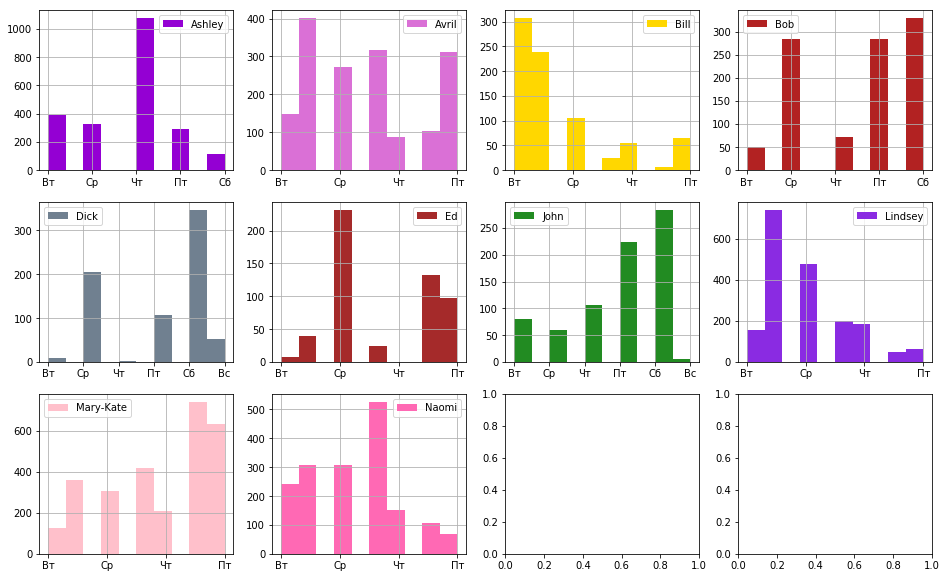

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
weekdays = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

indices = [(i, j) for i in range(3) for j in range(4)]
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['day_of_week'].hist(ax=axes[indices[idx]], color=color_dic[user])
    axes[indices[idx]].legend([user])
    axes[indices[idx]].set_xticklabels(weekdays)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Bill и Ashley часто заходят на один сайт. Dick и Mary-Kate - на два. У остальных распределение по уникальным сайтам примерно одинаковое. Ashley чаще всего заходит куда-либо днем. У Avril пик приходится на обед и вечер. У Bill - утро и обед. Bob, по-видимому, не сидит в интернете позднее 17 часов. У Dick и John пик приходится на утро и обед. John и Lindsey редко заходит в интернет вечером. У Mary-Kate пик приходится на вечер. Naomi почти не заходит  в интернет утром, пик приходится на обед. Ashley чаще всего заходит в интернет по четвергам. У Avril распределение по дням недели примерно равномерно. У Bill и Lindsey пик приходится на начало недели, к концу происходит постепенный спад. У John наблюдается обратная тенденция. У Dick два пика приходятся на среду и выходные. Во вторник и четверг он почти не сидит в интернете. У Mary-Kate и Naomi распределение в целом равномерно, но пик приходится на вторую половину недели.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
with open(f'{PATH_TO_DATA}\\site_freq_10users.pkl', 'rb') as f:
    vocab = pickle.load(f)

vocab_sort = list(vocab.items())
vocab_sort.sort(key=lambda x: x[1][1], reverse=True)

top10_freqs = [i[1][1] for i in vocab_sort[:10]]
top10_sites = [i[0] for i in vocab_sort[:10]]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

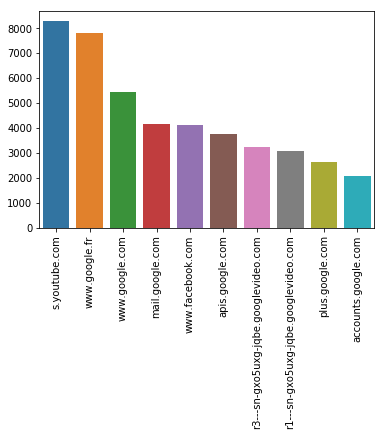

In [26]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation='vertical')

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [39]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    user_re = re.compile("user([\d]+)[.]")
    list_times_incomplete = []
    list_sites = []
    list_users = []
    list_timediffs = []
    
    with open(site_freq_path,"rb") as f:
        site_freq = pickle.load(f)

    for file in tqdm(glob(path_to_csv_files+'/*')):
        sites_raw = pd.read_csv(file)['site'].apply(lambda x: site_freq[x][0])
        timestamps_raw = pd.read_csv(file)['timestamp']

        indices = boundaries(len(sites_raw),session_length, 10)
        list_users += [int(re.search(user_re, file).group(1))] * len(indices)
        list_times_incomplete += [timestamps_raw.values[ind[0]:ind[1]].reshape(-1) for ind in indices]
        list_sites += [sites_raw.values[ind[0]:ind[1]].reshape(-1) for ind in indices]
        

    list_times = [list(map(np.datetime64, i)) for i in list_times_incomplete]
    total_time = [(i[-1]-i[0]).astype(int) for i in list_times]
    unique = [len(np.unique(i)) for i in list_sites]
    facebook_id = site_freq.get('www.facebook.com', (-1, -1))[0]
    google_id = site_freq.get('www.google.com', (-1, -1))[0]
    facebook_count = [list(i).count(facebook_id) for i in list_sites]
    google_count = [list(i).count(google_id) for i in list_sites]
    total_time = [(i[-1]-i[0]).astype(int) for i in list_times]    
    
    
    for session in list_times:
        localdiff = [(session[i]-session[i-1]).astype(int) for i in range(1, len(session))]
        list_timediffs.append(localdiff)
        
    df_tstamps = pd.DataFrame(list_times, columns=[f'time{i}' for i in range(session_length)])
    df_sites = pd.DataFrame(list_sites, columns=[f'site{i}' for i in range(1, session_length+1)])
    df_timediffs = pd.DataFrame(list_timediffs, columns=[f'time{i}' for i in range(1, session_length)]) 
    df = pd.concat([df_sites, df_timediffs], axis=1)
    df = df.fillna(0).astype('int')
    
    df['session_timespan'] = total_time
    df['#unique_sites'] = unique
    df['start_hour'] = df_tstamps['time0'].dt.hour
    df['day_of_week'] = df_tstamps['time0'].dt.dayofweek
    df['target'] = list_users
    df['facebook_visits'] = facebook_count
    df['google_visits'] = google_count
    df = df.loc[:, features]
    
    return df, df.values

In [28]:
features = ['facebook_visits', 'google_visits']

In [29]:
new_features_10users, _ = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), features=features)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00,  9.17it/s]


In [30]:
new_features_150users, _ = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'), features=features)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:07<00:00, 30.73it/s]


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

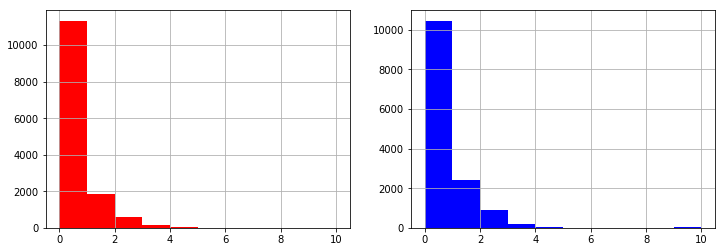

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
new_features_10users['facebook_visits'].hist(ax=ax1, color='red')
new_features_10users['google_visits'].hist(ax=ax2, color='blue')

In [32]:
new_features_10users['facebook_visits'].value_counts()

0     11336
1      1853
2       597
3       169
4        51
6        14
7        13
5        11
10        7
8         7
9         3
Name: facebook_visits, dtype: int64

In [33]:
new_features_10users['google_visits'].value_counts()

0     10450
1      2406
2       911
3       214
10       38
4        30
5         8
9         2
7         1
6         1
Name: google_visits, dtype: int64

Мы видим, что доля пользователей, посещающих гугл, больше, чем доля пользователей, не посещающих его. Доля пользователей, посетивших гугл 10 раз за сессию, также больше.

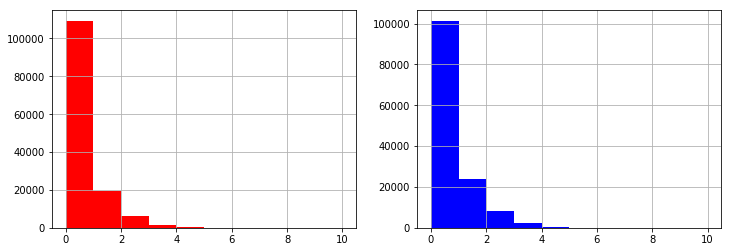

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
new_features_150users['facebook_visits'].hist(ax=ax1, color='red')
new_features_150users['google_visits'].hist(ax=ax2, color='blue')

In [35]:
new_features_150users['facebook_visits'].value_counts()

0     109353
1      19235
2       6316
3       1646
4        309
5         88
6         30
7         17
8         11
10         8
9          6
Name: facebook_visits, dtype: int64

In [36]:
new_features_150users['google_visits'].value_counts()

0     101419
1      24127
2       8386
3       2359
4        546
5        101
10        38
6         32
7          8
9          3
Name: google_visits, dtype: int64

Мы видим, что тенденция сохраняется и для 150  пользователей

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [37]:
features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [40]:
selected_features_10users, _ = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), features=features)
selected_features_150users, _ = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'), features=features) 

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:07<00:00, 20.27it/s]


In [41]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 